# seq2seq

機械翻訳、音声認識などのように、言語データ、音声データ、動画像などの時系列データを別の時系列データに変換する問題がある。<br>
その手法のひとつに、2つのRNNを使用する（**sequence to sequence**）がある。<br><br>
入力データをエンコードし、エンコードされたデータをデコードするモデルであることから、**Encoder-Decoderモデル**とも呼ばれる。

## seq2seqの構造

時系列変換モデルとして足し算を扱う。入力は7文字（35+13の場合は5文字）まで、出力は5文字までとする（パディングを行い文字数を調整する）。<br>
出力の先頭には、Decoderに文字列生成を知らせる合図として「_（アンダースコア）」をつける。

### Encoder

![](image/13_encoder.png)
Encoderでは、Embeddingでは文字IDをベクトルに変換し、最後の文字の処理後にLSTMレイヤの隠れ状態$\mathbf{h}$を出力し、Decoderに渡す。<br>
以下で、時間方向の処理をまとめて実装する。

In [4]:
from source.common02.time_layers import *

class Encoder:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx = (rn(D, 4 * H) / np.sqrt(D)).astype('f')
        lstm_Wh = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4 * H).astype('f')

        self.embed = TimeEmbedding(embed_W)
        self.lstm = TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=False)

        self.params = self.embed.params + self.lstm.params
        self.grads = self.embed.grads + self.lstm.grads
        self.hs = None

    def forward(self, xs):
        xs = self.embed.forward(xs)
        hs = self.lstm.forward(xs)
        self.hs = hs
        return hs[:, -1, :]

    def backward(self, dh):
        dhs = np.zeros_like(self.hs)
        dhs[:, -1, :] = dh

        dout = self.lstm.backward(dhs)
        dout = self.embed.backward(dout)
        return dout

### Decoder

DecoderはEncoderから渡された$\mathbf{h}$を受け取り、目的とする別の文字列を出力する。<br>
Decoderでは、学習時と生成時ではデータの与え方が異なる。<br><br>

![](image/13_decoder-learning.png)
これは、学習時のレイヤ構成。学習時は正解が分かっているため時系列データをまとめて与える。

![](image/13_decoder-generate.png)
これは、生成時のレイヤ構成。生成時は開始を知らせる区切り時（ここでは「_ 」）を1つ与える。「argmax」ノードで「決定的に」最大値を選ぶ。

In [5]:
from source.common02.time_layers import *

class Decoder:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx = (rn(D, 4 * H) / np.sqrt(D)).astype('f')
        lstm_Wh = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4 * H).astype('f')
        affine_W = (rn(H, V) / np.sqrt(H)).astype('f')
        affine_b = np.zeros(V).astype('f')

        self.embed = TimeEmbedding(embed_W)
        self.lstm = TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=True)
        self.affine = TimeAffine(affine_W, affine_b)

        self.params, self.grads = [], []
        for layer in (self.embed, self.lstm, self.affine):
            self.params += layer.params
            self.grads += layer.grads

    def forward(self, xs, h): # 計算グラフの通り
        self.lstm.set_state(h)

        out = self.embed.forward(xs)
        out = self.lstm.forward(out)
        score = self.affine.forward(out)
        return score

    def backward(self, dscore): # 計算グラフの通り
        dout = self.affine.backward(dscore)
        dout = self.lstm.backward(dout)
        dout = self.embed.backward(dout)
        dh = self.lstm.dh
        return dh

    def generate(self, h, start_id, sample_size):
        sampled = []
        sample_id = start_id
        self.lstm.set_state(h)

        for _ in range(sample_size):
            x = np.array(sample_id).reshape((1, 1))
            out = self.embed.forward(x)
            out = self.lstm.forward(out)
            score = self.affine.forward(out)

            sample_id = np.argmax(score.flatten())
            sampled.append(int(sample_id))

        return sampled

### Seq2seqクラス

EncoderクラスとDecoderクラスをつなぎ合わせ、Time Softmax with Lossレイヤを使い損失を計算する。

In [6]:
from source.common02.base_model import BaseModel

class Seq2seq(BaseModel):
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        self.encoder = Encoder(V, D, H)
        self.decoder = Decoder(V, D, H)
        self.softmax = TimeSoftmaxWithLoss()

        self.params = self.encoder.params + self.decoder.params
        self.grads = self.encoder.grads + self.decoder.grads

    def forward(self, xs, ts):
        decoder_xs, decoder_ts = ts[:, :-1], ts[:, 1:]

        h = self.encoder.forward(xs)
        score = self.decoder.forward(decoder_xs, h)
        loss = self.softmax.forward(score, decoder_ts)
        return loss

    def backward(self, dout=1):
        dout = self.softmax.backward(dout)
        dh = self.decoder.backward(dout)
        dout = self.encoder.backward(dh)
        return dout

    def generate(self, xs, start_id, sample_size):
        h = self.encoder.forward(xs)
        sampled = self.decoder.generate(h, start_id, sample_size)
        return sampled

## seq2seqの評価

seq2seqは、「ミニバッチを選ぶ」→「勾配を計算」→「パラメータを更新」の基本的なニューラルネットワークの学習と同じ流れ。

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from source.dataset02 import sequence
from source.common02.optimizer import Adam
from source.common02.trainer2 import Trainer2
from source.common02.util import *


# データセットの読み込み
(x_train, t_train), (x_test, t_test) = sequence.load_data('addition.txt')
char_to_id, id_to_char = sequence.get_vocab()

# ハイパーパラメータの設定
vocab_size = len(char_to_id)
wordvec_size = 16
hidden_size = 128
batch_size = 128
max_epoch = 25
max_grad = 5.0

#モデル / オプティマイザ / トレーナーの生成
model = Seq2seq(vocab_size, wordvec_size, hidden_size)
optimizer = Adam()
trainer = Trainer2(model, optimizer)

sum_acc_list = []
for epoch in range(max_epoch):
    trainer.fit(x_train, t_train, max_epoch=1,
                batch_size=batch_size, max_grad=max_grad)

    correct_num = 0
    for i in range(len(x_test)):
        question, correct = x_test[[i]], t_test[[i]]
        verbose = i < 10
        correct_num += silent_eval_seq2seq(model, question, correct,
                                    id_to_char, verbose)

    sum_acc = float(correct_num) / len(x_test)
    sum_acc_list.append(sum_acc)
    print('val acc %.3f%%' % (sum_acc * 100))

val acc 0.180%
val acc 0.220%
val acc 0.560%
val acc 1.060%
val acc 2.260%
val acc 1.800%
val acc 2.600%
val acc 3.380%
val acc 5.280%
val acc 5.880%
val acc 6.760%
val acc 3.500%
val acc 7.040%
val acc 7.900%
val acc 4.160%
val acc 6.840%
val acc 7.860%
val acc 7.720%
val acc 6.260%
val acc 9.000%
val acc 8.100%
val acc 7.920%
val acc 6.320%
val acc 11.740%
val acc 11.820%


評価指標として、正解率を採用する。`eval_seq2seq`は、モデルの出す答えが合っていれば1、間違っていれば0を返す。<br>
エポックを重ねるごとに正解率が徐々に上昇しているが、より効率良く学習できるようseq2seqを改良する。

## seq2seqの改良

### 入力データの反転（Reverse）

![](image/13_reverse.png)

|反転前|反転後|
|:-|:-|
|「吾輩 は 猫 で ある」→「I am a cat」|「ある で 猫 は 吾輩」→「I am a cat」|
|「2　2　0　+　8　・　・」→「_　2　2　8」|「・　・　8　+　0　2　2」→「_　2　2　8」|

学習効率が上がるのは、勾配の伝播がスムーズになるためと考えられる。<br><br>
通常、学習の際は、間にある語数分のLSTMレイヤを経由する必要があるが、反転させると入力の先頭部分は変換後の語との距離が近くなるため、勾配が伝わりやすく効率良く学習できるようになると考えられる（単語間の平均距離は変わらない）。

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from source.dataset02 import sequence
from source.common02.optimizer import Adam
from source.common02.trainer2 import Trainer2
from source.common02.util import eval_seq2seq


# データセットの読み込み
(x_train, t_train), (x_test, t_test) = sequence.load_data('addition.txt')
char_to_id, id_to_char = sequence.get_vocab()

# Reverse
is_reverse = True
x_train, x_test = x_train[:, ::-1], x_test[:, ::-1]

# ハイパーパラメータの設定
vocab_size = len(char_to_id)
wordvec_size = 16
hidden_size = 128
batch_size = 128
max_epoch = 25
max_grad = 5.0

#モデル / オプティマイザ / トレーナーの生成
model = Seq2seq(vocab_size, wordvec_size, hidden_size)
optimizer = Adam()
trainer = Trainer2(model, optimizer)

sum_rev_acc_list = []
for epoch in range(max_epoch):
    trainer.fit(x_train, t_train, max_epoch=1,
                batch_size=batch_size, max_grad=max_grad)

    correct_num = 0
    for i in range(len(x_test)):
        question, correct = x_test[[i]], t_test[[i]]
        verbose = i < 10
        correct_num += eval_seq2seq(model, question, correct,
                                    id_to_char, verbose, is_reverse)

    sum_rev_acc = float(correct_num) / len(x_test)
    sum_rev_acc_list.append(sum_rev_acc)
    print('val acc %.3f%%' % (sum_rev_acc * 100))

Q 77+85  
T 162 
☒ 100 
---
Q 975+164
T 1139
☒ 1000
---
Q 582+84 
T 666 
☒ 1001
---
Q 8+155  
T 163 
☒ 100 
---
Q 367+55 
T 422 
☒ 1001
---
Q 600+257
T 857 
☒ 1000
---
Q 761+292
T 1053
☒ 1000
---
Q 830+597
T 1427
☒ 1000
---
Q 26+838 
T 864 
☒ 1001
---
Q 143+93 
T 236 
☒ 703 
---
val acc 0.120%
Q 77+85  
T 162 
☒ 100 
---
Q 975+164
T 1139
☒ 1000
---
Q 582+84 
T 666 
☒ 690 
---
Q 8+155  
T 163 
☒ 1000
---
Q 367+55 
T 422 
☒ 470 
---
Q 600+257
T 857 
☒ 700 
---
Q 761+292
T 1053
☒ 1000
---
Q 830+597
T 1427
☒ 1444
---
Q 26+838 
T 864 
☒ 700 
---
Q 143+93 
T 236 
☒ 370 
---
val acc 0.400%
Q 77+85  
T 162 
☒ 158 
---
Q 975+164
T 1139
☒ 1148
---
Q 582+84 
T 666 
☒ 662 
---
Q 8+155  
T 163 
☒ 162 
---
Q 367+55 
T 422 
☒ 382 
---
Q 600+257
T 857 
☒ 818 
---
Q 761+292
T 1053
☒ 1008
---
Q 830+597
T 1427
☒ 1434
---
Q 26+838 
T 864 
☒ 838 
---
Q 143+93 
T 236 
☒ 202 
---
val acc 1.940%
Q 77+85  
T 162 
☒ 166 
---
Q 975+164
T 1139
☒ 1196
---
Q 582+84 
T 666 
☒ 668 
---
Q 8+155  
T 163 
☒ 166 
---
Q 3

val acc 47.780%
Q 77+85  
T 162 
☑ 162 
---
Q 975+164
T 1139
☒ 1142
---
Q 582+84 
T 666 
☑ 666 
---
Q 8+155  
T 163 
☑ 163 
---
Q 367+55 
T 422 
☑ 422 
---
Q 600+257
T 857 
☒ 858 
---
Q 761+292
T 1053
☑ 1053
---
Q 830+597
T 1427
☒ 1429
---
Q 26+838 
T 864 
☒ 866 
---
Q 143+93 
T 236 
☒ 238 
---
val acc 45.080%
Q 77+85  
T 162 
☑ 162 
---
Q 975+164
T 1139
☑ 1139
---
Q 582+84 
T 666 
☑ 666 
---
Q 8+155  
T 163 
☑ 163 
---
Q 367+55 
T 422 
☒ 421 
---
Q 600+257
T 857 
☑ 857 
---
Q 761+292
T 1053
☒ 1054
---
Q 830+597
T 1427
☒ 1428
---
Q 26+838 
T 864 
☑ 864 
---
Q 143+93 
T 236 
☒ 237 
---
val acc 52.020%
Q 77+85  
T 162 
☑ 162 
---
Q 975+164
T 1139
☒ 1140
---
Q 582+84 
T 666 
☑ 666 
---
Q 8+155  
T 163 
☑ 163 
---
Q 367+55 
T 422 
☑ 422 
---
Q 600+257
T 857 
☒ 856 
---
Q 761+292
T 1053
☒ 1052
---
Q 830+597
T 1427
☒ 1426
---
Q 26+838 
T 864 
☑ 864 
---
Q 143+93 
T 236 
☑ 236 
---
val acc 54.360%


上では、精度とともに学習した計算過程の例を示している。少しずつ正解率が高まっている。

### 覗き見（Peeky）

![](image/13_peeky.png)

Decoderの情報源である唯一のベクトルは、最初のLSTMレイヤでのみ利用されているが、このベクトルを全ての「Affineレイヤ」と「LSTMレイヤ」で共有することでモデルの改良が期待できる。

In [9]:
class PeekyDecoder:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx = (rn(H + D, 4 * H) / np.sqrt(H + D)).astype('f') # 重みが増加
        lstm_Wh = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4 * H).astype('f')
        affine_W = (rn(H + H, V) / np.sqrt(H + H)).astype('f') # 重みが増加
        affine_b = np.zeros(V).astype('f')

        self.embed = TimeEmbedding(embed_W)
        self.lstm = TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=True)
        self.affine = TimeAffine(affine_W, affine_b)

        self.params, self.grads = [], []
        for layer in (self.embed, self.lstm, self.affine):
            self.params += layer.params
            self.grads += layer.grads
        self.cache = None

    def forward(self, xs, h):
        N, T = xs.shape
        N, H = h.shape

        self.lstm.set_state(h)

        out = self.embed.forward(xs)
        hs = np.repeat(h, T, axis=0).reshape(N, T, H) # hを時系列分複製
        out = np.concatenate((hs, out), axis=2) # 連結

        out = self.lstm.forward(out)
        out = np.concatenate((hs, out), axis=2)

        score = self.affine.forward(out)
        self.cache = H
        return score

    def backward(self, dscore):
        H = self.cache

        dout = self.affine.backward(dscore)
        dout, dhs0 = dout[:, :, H:], dout[:, :, :H]
        dout = self.lstm.backward(dout)
        dembed, dhs1 = dout[:, :, H:], dout[:, :, :H]
        self.embed.backward(dembed)

        dhs = dhs0 + dhs1
        dh = self.lstm.dh + np.sum(dhs, axis=1)
        return dh

    def generate(self, h, start_id, sample_size):
        sampled = []
        char_id = start_id
        self.lstm.set_state(h)

        H = h.shape[1]
        peeky_h = h.reshape(1, 1, H)
        for _ in range(sample_size):
            x = np.array([char_id]).reshape((1, 1))
            out = self.embed.forward(x)

            out = np.concatenate((peeky_h, out), axis=2)
            out = self.lstm.forward(out)
            out = np.concatenate((peeky_h, out), axis=2)
            score = self.affine.forward(out)

            char_id = np.argmax(score.flatten())
            sampled.append(char_id)

        return sampled

In [10]:
class PeekySeq2seq(Seq2seq):
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        self.encoder = Encoder(V, D, H)
        self.decoder = PeekyDecoder(V, D, H)
        self.softmax = TimeSoftmaxWithLoss()

        self.params = self.encoder.params + self.decoder.params
        self.grads = self.encoder.grads + self.decoder.grads

### 改良seq2seqの実装

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from source.dataset02 import sequence
from source.common02.optimizer import Adam
from source.common02.trainer2 import Trainer2
from source.common02.util import *


# データセットの読み込み
(x_train, t_train), (x_test, t_test) = sequence.load_data('addition.txt')
char_to_id, id_to_char = sequence.get_vocab()

# Reverse
x_train, x_test = x_train[:, ::-1], x_test[:, ::-1]

# ハイパーパラメータの設定
vocab_size = len(char_to_id)
wordvec_size = 16
hidden_size = 128
batch_size = 128
max_epoch = 25
max_grad = 5.0

# Peeky
model = PeekySeq2seq(vocab_size, wordvec_size, hidden_size)
optimizer = Adam()
trainer = Trainer2(model, optimizer)

sum_imp_acc_list = []
for epoch in range(max_epoch):
    trainer.fit(x_train, t_train, max_epoch=1,
                batch_size=batch_size, max_grad=max_grad)

    correct_num = 0
    for i in range(len(x_test)):
        question, correct = x_test[[i]], t_test[[i]]
        verbose = i < 10
        correct_num += silent_eval_seq2seq(model, question, correct,
                                    id_to_char, verbose, is_reverse)

    sum_imp_acc = float(correct_num) / len(x_test)
    sum_imp_acc_list.append(sum_imp_acc)
    print('val acc %.3f%%' % (sum_imp_acc * 100))

val acc 0.280%
val acc 0.400%
val acc 1.600%
val acc 5.140%
val acc 9.380%
val acc 15.040%
val acc 39.100%
val acc 65.060%
val acc 83.280%
val acc 88.400%
val acc 90.940%
val acc 92.240%
val acc 94.380%
val acc 96.060%
val acc 96.040%
val acc 96.820%
val acc 96.400%
val acc 97.080%
val acc 97.440%
val acc 95.960%
val acc 98.560%
val acc 97.100%
val acc 98.840%
val acc 93.680%
val acc 98.300%


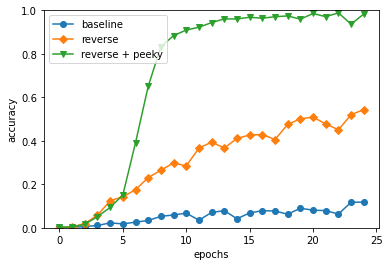

In [12]:
# グラフの描画
x = np.arange(len(sum_acc_list))
plt.plot(x, sum_acc_list, marker='o')
plt.plot(x, sum_rev_acc_list, marker='D')
plt.plot(x, sum_imp_acc_list, marker='v')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.ylim(0, 1.0)
plt.legend(["baseline", "reverse", "reverse + peeky"])
plt.show()

ベースモデルは着実に学習を進めてはいるが、効率があまり良くない。入力データを反転させるだけでも学習効率はかなり良くなるが、ベクトルを共有する改良もすることによって精度は早い段階で9割を超えるようになる。

## アプリケーションの例

- 機械翻訳
<br><br>
- 自動要約
<br><br>
- 質疑応答
<br><br>
- 自動返信
<br><br>
- チャットボット
<br><br>
- アルゴリズムの学習
<br><br>
- イメージキャプション
 1. EncoderがLSTMからCNNに置き換わる
 2. CNNの出力である3次元の特徴マップを、全結合アフィン変換を適用し1次元に
 3. Decoderに渡し文章生成

## 問題点

seq2seqでは、入力の大きさに関わらず、「固定長」のベクトルにエンコードする。これには構造上の限界があるため、以下で改良をする。

# Attention

## Attentionの構造

Encoderにおいて、各時刻の隠れ状態には直前に入力された情報が多く含まれているため、各時刻のLSTMレイヤの隠れ状態ベクトルを全て利用し、各時刻における情報に対応したベクトルの集合を得るようにする。

Decoderにおいて、入力と出力の対応関係を表す情報（**アラインメント**）のみに注意を向け、その情報から時系列変換を行う。この仕組みは**Attention**と呼ばれる。

対応するベクトルを「選ぶ」という操作は微分ができず、逆伝播ができないため、各単語の重み付き和を求めることで選ぶ操作に代える。

In [13]:
from source.common02.np import *


class WeightSum:
    def __init__(self):
        self.params, self.grads = [], []
        self.cache = None

    def forward(self, hs, a):
        N, T, H = hs.shape

        ar = a.reshape(N, T, 1) #.repeat(T, axis=1) repeatをするのが正しいが、numpyのブロードキャストの方が速い
        t = hs * ar
        c = np.sum(t, axis=1)

        self.cache = (hs, ar)
        return c

    def backward(self, dc):
        hs, ar = self.cache
        N, T, H = hs.shape
        dt = dc.reshape(N, 1, H).repeat(T, axis=1)
        dar = dt * hs
        dhs = dt * ar
        da = np.sum(dar, axis=2)

        return dhs, da

以下で、各単語の重みを求める処理を実装する。

In [14]:
from source.common02.np import *
from source.common02.layers import Softmax


class AttentionWeight:
    def __init__(self):
        self.params, self.grads = [], []
        self.softmax = Softmax()
        self.cache = None

    def forward(self, hs, h):
        N, T, H = hs.shape

        hr = h.reshape(N, 1, H)#.repeat(T, axis=1)
        t = hs * hr
        s = np.sum(t, axis=2)
        a = self.softmax.forward(s)

        self.cache = (hs, hr)
        return a

    def backward(self, da):
        hs, hr = self.cache
        N, T, H = hs.shape

        ds = self.softmax.backward(da)
        dt = ds.reshape(N, T, 1).repeat(H, axis=2)
        dhs = dt * hr
        dhr = dt * hs
        dh = np.sum(dhr, axis=1)

        return dhs, dh

これらの処理をAttentionレイヤとして実装する。<br>
1. Encoderから各単語のベクトル$\mathbf{hs}$を受け取る
2. Attention Weightレイヤが各単語の重み$\mathbf{a}$を求める（注意を払う）
3. Weight Sumレイヤが$\mathbf{a}$と$\mathbf{hs}$の重み付き和をコンテキストベクトル$\mathbf{c}$として出力

In [15]:
class Attention:
    def __init__(self):
        self.params, self.grads = [], []
        self.attention_weight_layer = AttentionWeight()
        self.weight_sum_layer = WeightSum()
        self.attention_weight = None

    def forward(self, hs, h):
        a = self.attention_weight_layer.forward(hs, h)
        out = self.weight_sum_layer.forward(hs, a)
        self.attention_weight = a
        return out

    def backward(self, dout):
        dhs0, da = self.weight_sum_layer.backward(dout)
        dhs1, dh = self.attention_weight_layer.backward(da)
        dhs = dhs0 + dhs1
        return dhs, dh

時系列方向の処理をまとめて行うクラスを実装する。

In [16]:
class TimeAttention:
    def __init__(self):
        self.params, self.grads = [], []
        self.layers = None
        self.attention_weights = None

    def forward(self, hs_enc, hs_dec):
        N, T, H = hs_dec.shape
        out = np.empty_like(hs_dec)
        self.layers = []
        self.attention_weights = []

        for t in range(T):
            layer = Attention()
            out[:, t, :] = layer.forward(hs_enc, hs_dec[:,t,:])
            self.layers.append(layer)
            self.attention_weights.append(layer.attention_weight)

        return out

    def backward(self, dout):
        N, T, H = dout.shape
        dhs_enc = 0
        dhs_dec = np.empty_like(dout)

        for t in range(T):
            layer = self.layers[t]
            dhs, dh = layer.backward(dout[:, t, :])
            dhs_enc += dhs
            dhs_dec[:,t,:] = dh

        return dhs_enc, dhs_dec

## Attention付きseq2seq

### Encoder

![](image/13_attention-encoder.png)
各時刻の隠れ状態ベクトルの集合を出力する。<br>
計算グラフの通り実装する。

In [17]:
class AttentionEncoder(Encoder):
    def forward(self, xs):
        xs = self.embed.forward(xs)
        hs = self.lstm.forward(xs)
        return hs

    def backward(self, dhs):
        dout = self.lstm.backward(dhs)
        dout = self.embed.backward(dout)
        return dout

### Decoder

![](image/13_attention-decoder.png)

AttentionレイヤをLSTMレイヤとAffineレイヤの間に挿入する。<br>
計算グラフの通り実装する。

In [18]:
class AttentionDecoder:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx = (rn(D, 4 * H) / np.sqrt(D)).astype('f')
        lstm_Wh = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4 * H).astype('f')
        affine_W = (rn(2*H, V) / np.sqrt(2*H)).astype('f')
        affine_b = np.zeros(V).astype('f')

        self.embed = TimeEmbedding(embed_W)
        self.lstm = TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=True)
        self.attention = TimeAttention()
        self.affine = TimeAffine(affine_W, affine_b)
        layers = [self.embed, self.lstm, self.attention, self.affine]

        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads

    def forward(self, xs, enc_hs):
        h = enc_hs[:,-1]
        self.lstm.set_state(h)

        out = self.embed.forward(xs)
        dec_hs = self.lstm.forward(out)
        c = self.attention.forward(enc_hs, dec_hs)
        out = np.concatenate((c, dec_hs), axis=2)
        score = self.affine.forward(out)

        return score

    def backward(self, dscore):
        dout = self.affine.backward(dscore)
        N, T, H2 = dout.shape
        H = H2 // 2

        dc, ddec_hs0 = dout[:,:,:H], dout[:,:,H:]
        denc_hs, ddec_hs1 = self.attention.backward(dc)
        ddec_hs = ddec_hs0 + ddec_hs1
        dout = self.lstm.backward(ddec_hs)
        dh = self.lstm.dh
        denc_hs[:, -1] += dh
        self.embed.backward(dout)

        return denc_hs

    def generate(self, enc_hs, start_id, sample_size):
        sampled = []
        sample_id = start_id
        h = enc_hs[:, -1]
        self.lstm.set_state(h)

        for _ in range(sample_size):
            x = np.array([sample_id]).reshape((1, 1))

            out = self.embed.forward(x)
            dec_hs = self.lstm.forward(out)
            c = self.attention.forward(enc_hs, dec_hs)
            out = np.concatenate((c, dec_hs), axis=2)
            score = self.affine.forward(out)

            sample_id = np.argmax(score.flatten())
            sampled.append(sample_id)

        return sampled

ここではAffineレイヤがコンテキストベクトルを受け取るが、次時刻のLSTMレイヤが受け取るモデルもある。<br>
これらは両者ともコンテキストベクトルが有効活用される構成であり、精度にどのように影響するかは、実際のデータによる検証でのみ説明可能である。<br><br>
なお、前者（上で実装したもの）はDecoderでのデータの流れが一方向であるため、Attentionレイヤのモジュール化が容易であり、実装が簡単。<br><br>
この他にも、Attentionの適用の仕方は様々にある。

### AttentionSeq2seqクラス

In [19]:
class AttentionSeq2seq(Seq2seq):
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        args = vocab_size, wordvec_size, hidden_size
        self.encoder = AttentionEncoder(*args)
        self.decoder = AttentionDecoder(*args)
        self.softmax = TimeSoftmaxWithLoss()

        self.params = self.encoder.params + self.decoder.params
        self.grads = self.encoder.grads + self.decoder.grads

## Attentionの評価

### 足し算問題

先の足し算の問題をAttentionを適用して解く。

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from source.dataset02 import sequence
from source.common02.optimizer import Adam
from source.common02.trainer2 import Trainer2
from source.common02.util import *


# データセットの読み込み
(x_train, t_train), (x_test, t_test) = sequence.load_data('addition.txt')
char_to_id, id_to_char = sequence.get_vocab()

# Reverse
x_train, x_test = x_train[:, ::-1], x_test[:, ::-1]

# ハイパーパラメータの設定
vocab_size = len(char_to_id)
wordvec_size = 16
hidden_size = 128
batch_size = 128
max_epoch = 25
max_grad = 5.0

model = AttentionSeq2seq(vocab_size, wordvec_size, hidden_size)
optimizer = Adam()
trainer = Trainer2(model, optimizer)

sum_att_acc_list = []
for epoch in range(max_epoch):
    trainer.fit(x_train, t_train, max_epoch=1,
                batch_size=batch_size, max_grad=max_grad)

    correct_num = 0
    for i in range(len(x_test)):
        question, correct = x_test[[i]], t_test[[i]]
        verbose = i < 10
        correct_num += silent_eval_seq2seq(model, question, correct,
                                    id_to_char, verbose, is_reverse)

    sum_att_acc = float(correct_num) / len(x_test)
    sum_att_acc_list.append(sum_att_acc)
    print('val acc %.3f%%' % (sum_att_acc * 100))

val acc 0.160%
val acc 0.320%
val acc 0.560%
val acc 1.140%
val acc 1.680%
val acc 2.320%
val acc 4.440%
val acc 6.520%
val acc 9.200%
val acc 11.540%
val acc 13.180%
val acc 15.640%
val acc 20.280%
val acc 21.800%
val acc 30.680%
val acc 37.680%
val acc 44.480%
val acc 54.880%
val acc 59.540%
val acc 65.500%
val acc 73.740%
val acc 79.220%
val acc 82.920%
val acc 85.680%
val acc 88.760%


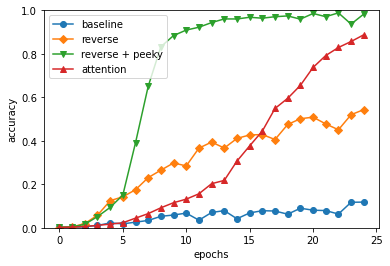

In [21]:
# グラフの描画
x = np.arange(len(sum_acc_list))
plt.plot(x, sum_acc_list, marker='o')
plt.plot(x, sum_rev_acc_list, marker='D')
plt.plot(x, sum_imp_acc_list, marker='v')
plt.plot(x, sum_att_acc_list, marker='^')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.ylim(0, 1.0)
plt.legend(["baseline", "reverse", "reverse + peeky", "attention"])
plt.show()

足し算問題ではAttentionはpeekyよりも学習が劣る結果になった。<br>
しかし、足し算問題では特別に注意を払うべき対応関係がほとんどないと考えられ、Attentionの強みを活かせていない可能性がある。

### 日付フォーマット変換問題

#### Attention

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from source.dataset02 import sequence
from source.common02.optimizer import Adam
from source.common02.trainer2 import Trainer2
from source.common02.util import *


# データの読み込み
(x_train, t_train), (x_test, t_test) = sequence.load_data('date.txt')
char_to_id, id_to_char = sequence.get_vocab()

# Reverse
x_train, x_test = x_train[:, ::-1], x_test[:, ::-1]

# ハイパーパラメータの設定b
vocab_size = len(char_to_id)
wordvec_size = 16
hidden_size = 256
batch_size = 128
max_epoch = 10
max_grad = 5.0

# Attention
model = AttentionSeq2seq(vocab_size, wordvec_size, hidden_size)
optimizer = Adam()
trainer = Trainer2(model, optimizer)

att_acc_list = []
for epoch in range(max_epoch):
    trainer.fit(x_train, t_train, max_epoch=1,
                batch_size=batch_size, max_grad=max_grad)

    correct_num = 0
    for i in range(len(x_test)):
        question, correct = x_test[[i]], t_test[[i]]
        verbose = i < 10
        correct_num += silent_eval_seq2seq(model, question, correct,
                                    id_to_char, verbose, is_reverse=True)

    att_acc = float(correct_num) / len(x_test)
    att_acc_list.append(att_acc)
    print('val acc %.3f%%' % (att_acc * 100))


model.save_params()

val acc 0.020%
val acc 90.760%
val acc 99.860%
val acc 99.980%
val acc 100.000%
val acc 100.000%
val acc 100.000%
val acc 100.000%
val acc 100.000%
val acc 100.000%


2エポック終了時点で正解率は90％を超えており、エポック5終了時点で100％に達する。学習がとても高速に行われている。

#### baseline

比較のため、ベースモデル、Peekyモデルについても学習する。なお、全てReverseを適用する。

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from source.dataset02 import sequence
from source.common02.optimizer import Adam
from source.common02.trainer2 import Trainer2
from source.common02.util import *


# データの読み込み
(x_train, t_train), (x_test, t_test) = sequence.load_data('date.txt')
char_to_id, id_to_char = sequence.get_vocab()

# 入力文を反転
x_train, x_test = x_train[:, ::-1], x_test[:, ::-1]

# ハイパーパラメータの設定
vocab_size = len(char_to_id)
wordvec_size = 16
hidden_size = 256
batch_size = 128
max_epoch = 10
max_grad = 5.0

# baseline
model = Seq2seq(vocab_size, wordvec_size, hidden_size)
optimizer = Adam()
trainer = Trainer2(model, optimizer)

acc_list = []
for epoch in range(max_epoch):
    trainer.fit(x_train, t_train, max_epoch=1,
                batch_size=batch_size, max_grad=max_grad)

    correct_num = 0
    for i in range(len(x_test)):
        question, correct = x_test[[i]], t_test[[i]]
        verbose = i < 10
        correct_num += silent_eval_seq2seq(model, question, correct,
                                    id_to_char, verbose, is_reverse=True)

    acc = float(correct_num) / len(x_test)
    acc_list.append(acc)
    print('val acc %.3f%%' % (acc * 100))

val acc 0.000%
val acc 0.020%
val acc 0.020%
val acc 0.000%
val acc 0.020%
val acc 0.000%
val acc 0.000%
val acc 0.000%
val acc 0.020%
val acc 0.020%


#### Peeky

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from source.dataset02 import sequence
from source.common02.optimizer import Adam
from source.common02.trainer2 import Trainer2
from source.common02.util import *


# データの読み込み
(x_train, t_train), (x_test, t_test) = sequence.load_data('date.txt')
char_to_id, id_to_char = sequence.get_vocab()

# 入力文を反転
x_train, x_test = x_train[:, ::-1], x_test[:, ::-1]

# ハイパーパラメータの設定
vocab_size = len(char_to_id)
wordvec_size = 16
hidden_size = 256
batch_size = 128
max_epoch = 10
max_grad = 5.0

# peeky
model = PeekySeq2seq(vocab_size, wordvec_size, hidden_size)
optimizer = Adam()
trainer = Trainer2(model, optimizer)

pky_acc_list = []
for epoch in range(max_epoch):
    trainer.fit(x_train, t_train, max_epoch=1,
                batch_size=batch_size, max_grad=max_grad)

    correct_num = 0
    for i in range(len(x_test)):
        question, correct = x_test[[i]], t_test[[i]]
        verbose = i < 10
        correct_num += silent_eval_seq2seq(model, question, correct,
                                    id_to_char, verbose, is_reverse=True)

    pky_acc = float(correct_num) / len(x_test)
    pky_acc_list.append(pky_acc)
    print('val acc %.3f%%' % (pky_acc * 100))

val acc 0.020%
val acc 0.280%
val acc 34.780%
val acc 92.120%
val acc 99.880%
val acc 100.000%
val acc 100.000%
val acc 100.000%
val acc 99.700%
val acc 99.960%


以上のbaseline、Peeky、Attentionについて、以下で学習の進行具合を比較する。

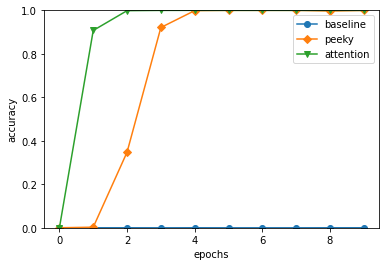

In [25]:
# グラフの描画
x = np.arange(len(acc_list))
plt.plot(x, acc_list, marker='o')
plt.plot(x, pky_acc_list, marker='D')
plt.plot(x, att_acc_list, marker='v')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.ylim(0, 1.0)
plt.legend(["baseline", "peeky", "attention"])
plt.show()

単純なseq2seqは精度の向上が見られないが、AttentionとPeekyは最終的にともに正解率が100％に達している。<br>
ここではAttentionとPeekyにあまり差はないが、時系列データがより長く複雑になると、学習速度、精度の点でAttentionが優勢になる。

### Attentionの可視化

Attentionがどの要素に注意を払っているかを可視化する。先のAttentionクラスで、各時刻のAttentionの重み（確率）をメンバ変数として保持してある。

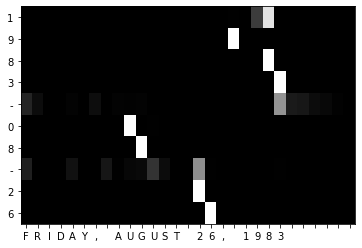

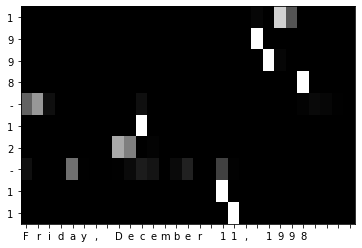

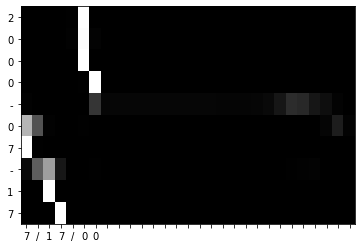

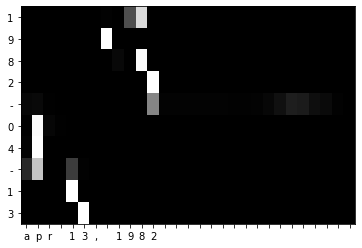

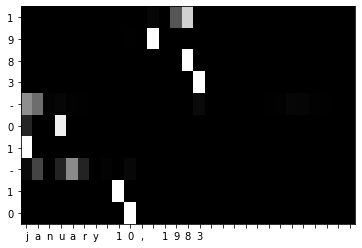

In [26]:
import numpy as np
from source.dataset02 import sequence
import matplotlib.pyplot as plt


(x_train, t_train), (x_test, t_test) = \
    sequence.load_data('date.txt')
char_to_id, id_to_char = sequence.get_vocab()

# Reverse input
x_train, x_test = x_train[:, ::-1], x_test[:, ::-1]

vocab_size = len(char_to_id)
wordvec_size = 16
hidden_size = 256

model = AttentionSeq2seq(vocab_size, wordvec_size, hidden_size)
model.load_params()

_idx = 0
def visualize(attention_map, row_labels, column_labels):
    fig, ax = plt.subplots()
    ax.pcolor(attention_map, cmap=plt.cm.Greys_r, vmin=0.0, vmax=1.0)

    ax.patch.set_facecolor('black')
    ax.set_yticks(np.arange(attention_map.shape[0])+0.5, minor=False)
    ax.set_xticks(np.arange(attention_map.shape[1])+0.5, minor=False)
    ax.invert_yaxis()
    ax.set_xticklabels(row_labels, minor=False)
    ax.set_yticklabels(column_labels, minor=False)

    global _idx
    _idx += 1
    plt.show()


np.random.seed(1984)
for _ in range(5):
    idx = [np.random.randint(0, len(x_test))]
    x = x_test[idx]
    t = t_test[idx]

    model.forward(x, t)
    d = model.decoder.attention.attention_weights
    d = np.array(d)
    attention_map = d.reshape(d.shape[0], d.shape[2])

    # reverse for print
    attention_map = attention_map[:,::-1]
    x = x[:,::-1]

    row_labels = [id_to_char[i] for i in x[0]]
    column_labels = [id_to_char[i] for i in t[0]]
    column_labels = column_labels[1:]

    visualize(attention_map, row_labels, column_labels)

Attentionは、縦軸（出力）と横軸（入力）の対応関係（08とAUGUSTなど）を学習している。<br>
PeekyよりAttentionの方がわずかながら優勢な結果になったのは、Attentionが注目すべき対応要素を見つけられたからであると考えられる。

## その他の改良

### 双方向RNN（Bidirectional RNN）

seq2seqのEncoderにおいて、各時刻時点での隠れ状態ベクトルはそれ以前の時刻の情報しか含んでいない。<br>
全体のバランスの取れた情報をエンコードするために、双方向から処理する。<br><br>
レイヤの種類によって、双方向LSTM（**BiLSTM**）、双方向GRU（**BiGRU**）などと呼ばれる。

以下で、双方向LSTMレイヤの実装と、Encoderに双方向LSTMの構造を持つAttention付きseq2seqの実装をする。

In [27]:
class TimeBiLSTM:
    def __init__(self, Wx1, Wh1, b1,
                 Wx2, Wh2, b2, stateful=False):
        self.forward_lstm = TimeLSTM(Wx1, Wh1, b1, stateful)
        self.backward_lstm = TimeLSTM(Wx2, Wh2, b2, stateful)
        self.params = self.forward_lstm.params + self.backward_lstm.params
        self.grads = self.forward_lstm.grads + self.backward_lstm.grads

    def forward(self, xs):
        o1 = self.forward_lstm.forward(xs)
        o2 = self.backward_lstm.forward(xs[:, ::-1])
        o2 = o2[:, ::-1]

        out = np.concatenate((o1, o2), axis=2)
        return out

    def backward(self, dhs):
        H = dhs.shape[2] // 2
        do1 = dhs[:, :, :H]
        do2 = dhs[:, :, H:]

        dxs1 = self.forward_lstm.backward(do1)
        do2 = do2[:, ::-1]
        dxs2 = self.backward_lstm.backward(do2)
        dxs2 = dxs2[:, ::-1]
        dxs = dxs1 + dxs2
        return dxs

In [28]:
class AttentionBiEncoder(AttentionEncoder):
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        embed_W = (rn(V, D) / 100).astype('f')

        # 双方向
        lstm_Wx1 = (rn(D, 4 * H) / np.sqrt(D)).astype('f')
        lstm_Wh1 = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b1 = np.zeros(4 * H).astype('f')

        lstm_Wx2 = (rn(D, 4 * H) / np.sqrt(D)).astype('f')
        lstm_Wh2 = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b2 = np.zeros(4 * H).astype('f')

        self.embed = TimeEmbedding(embed_W)
        self.lstm = TimeBiLSTM(lstm_Wx1, lstm_Wh1, lstm_b1, lstm_Wx2, lstm_Wh2, lstm_b2, stateful=False)

        self.params = self.embed.params + self.lstm.params
        self.grads = self.embed.grads + self.lstm.grads
        self.hs = None  

        
class AttentionBiDecoder(AttentionDecoder):
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        embed_W = (rn(V, D) / 100).astype('f')

        # Encoderからの入力が2倍
        lstm_Wx = (rn(D, 8 * H) / np.sqrt(D)).astype('f')
        lstm_Wh = (rn(2 * H, 8 * H) / np.sqrt(2 * H)).astype('f')
        lstm_b = np.zeros(8 * H).astype('f')
        affine_W = (rn(4 * H, V) / np.sqrt(4 * H)).astype('f')
        affine_b = np.zeros(V).astype('f')

        self.embed = TimeEmbedding(embed_W)
        self.lstm = TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=True)
        self.attention = TimeAttention()
        self.affine = TimeAffine(affine_W, affine_b)
        layers = [self.embed, self.lstm, self.attention, self.affine]

        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads  
      
    
class AttentionBiSeq2seq(Seq2seq):
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        self.encoder = AttentionBiEncoder(V, D, H)
        self.decoder = AttentionBiDecoder(V, D, H)
        self.softmax = TimeSoftmaxWithLoss()

        self.params = self.encoder.params + self.decoder.params
        self.grads = self.encoder.grads + self.decoder.grads

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from source.dataset02 import sequence
from source.common02.optimizer import Adam
from source.common02.trainer2 import Trainer2
from source.common02.util import *


# データの読み込み
(x_train, t_train), (x_test, t_test) = sequence.load_data('date.txt')
char_to_id, id_to_char = sequence.get_vocab()

# 入力文を反転
x_train, x_test = x_train[:, ::-1], x_test[:, ::-1]

# ハイパーパラメータの設定
vocab_size = len(char_to_id)
wordvec_size = 16
hidden_size = 256
batch_size = 128
max_epoch = 10
max_grad = 5.0

model = AttentionBiSeq2seq(vocab_size, wordvec_size, hidden_size)
optimizer = Adam()
trainer = Trainer2(model, optimizer)

bi_acc_list = []
for epoch in range(max_epoch):
    trainer.fit(x_train, t_train, max_epoch=1,
                batch_size=batch_size, max_grad=max_grad)

    correct_num = 0
    for i in range(len(x_test)):
        question, correct = x_test[[i]], t_test[[i]]
        verbose = i < 10
        correct_num += silent_eval_seq2seq(model, question, correct,
                                    id_to_char, verbose, is_reverse=True)

    bi_acc = float(correct_num) / len(x_test)
    bi_acc_list.append(bi_acc)
    print('val acc %.3f%%' % (bi_acc * 100))


model.save_params()

val acc 0.100%
val acc 0.160%
val acc 2.120%
val acc 27.540%
val acc 75.820%
val acc 97.460%
val acc 99.100%
val acc 99.440%
val acc 100.000%
val acc 100.000%


以下で、単方向LSTMと、双方向LSTMを比較する。どちらともAttention付きである。

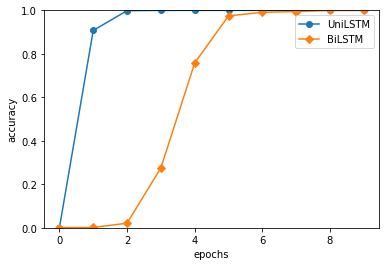

In [30]:
# グラフの描画
x = np.arange(len(acc_list))
plt.plot(x, att_acc_list, marker='o')
plt.plot(x, bi_acc_list, marker='D')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.ylim(0, 1.0)
plt.legend(["UniLSTM", "BiLSTM"])
plt.show()

この場合ではBiLSTMの方が学習が遅れている。<br>
しかしBiLSTMの強みは過去と未来の両方から情報を保存できることであり、この日付フォーマット変換問題では強みを活かせていない可能性がある。<br><br>
時系列方向に複雑な、機械翻訳やイメージキャプション生成などの問題ではBiLSTMの方が優勢になると考えられる。

### 深層化とskipコネクション

翻訳などの複雑な問題では、例の如くネットワークの深層化をし、表現力を高める必要がある。<br>
EncoderとDecoderで同じ層数のRNN（LSTM・GRU）レイヤを重ねるのが一般的。<br><br>
層を深くする際は、汎化性能を落とさないためにDropoutや重み共有、L2正則化などの工夫をする。<br>
また**ResNet**のように逆伝播時に勾配をそのまま流し、勾配消失を防ぐ「skipコネクション」も有効。

# Attentionの最先端の研究

以下に示す研究は全てAttentionが重要な役割を担っている。今後のますますの利用が考えられる。

## Google Neural Machine Translation（GNMT）

EncoderとDecoder、Attentionからなる。またLSTMの多層化や、Encoderの1層目での双方向LSTM、skipコネクションなど多くの工夫がある。<br>
他にも推論時の高速化のための量子化や、低頻出単語の対応など様々に工夫されている。<br><br>
これは大量のデータと大量の計算リソースがあって成し遂げられたものである。

## Transformer

RNNは時系列方向に逐次的に処理をするため、GPUを利用した並列処理が基本的にはできない。<br>
Transformerでは、一つの時系列データ内における各要素の対応関係を求める**Self-Attention**というテクニックが利用される。<br><br>
これにより計算量を抑え、GPUの恩恵をより多く受けることができ、学習時間を大幅に減らすことに成功し、精度もGNMTを一部で上回った。<br>
AttentionがRNNを置き換えるモジュールとしても利用可能であり、Attentionは有望な技術といえる。

## Neural Turing Machine（NTM）

RNNやLSTMは内部状態を使い時系列データを記憶したが、外部に記憶装置（外部メモリ）を配置すると、NTMは適宜記憶する。<br>
NTMは外部メモリに対しコンピュータのように読み書きを行い、データからプログラムを学習、つまり**アルゴリズム自体を学習できる**ということを意味する。<br><br>
NTMでは2つのAttentionを利用することでコンピュータの操作を模倣する。<br>
NTMはさらにこのようなメモリ操作を微分可能な計算で実現し、seq2seqが解けないような複雑な問題に対しても驚くべき成果を上げている。